# Testing of features in polymerist

In [ ]:
# Supressing annoying warnings (!must be done first!)
import warnings
warnings.catch_warnings(record=True)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

# Logging
from polymerist.genutils.logutils.IOHandlers import LOG_FORMATTER

import logging
logging.basicConfig(
    level=logging.INFO,
    format =LOG_FORMATTER._fmt,
    datefmt=LOG_FORMATTER.datefmt,
    force=True
)
LOGGER = logging.getLogger(__name__)

# General
import re, json
from pathlib import Path
from shutil import copyfile

import numpy as np
import matplotlib.pyplot as plt

# Logging
from rich.progress import Progress, track
import logging

# Chemistry
from openmm.unit import nanometer, angstrom
from openff.toolkit import Topology, Molecule, ForceField
from openff.units import unit as offunit

from openff.interchange import Interchange
from openff.interchange.components import _packmol as packmol

from rdkit import Chem
import openeye

# Custom
import polymerist as ps2
from polymerist.genutils.decorators.functional import allow_string_paths, allow_pathlib_paths, optional_in_place

## Testing combinatorics utils

In [17]:
from polymerist.genutils import iteration
from polymerist.maths.combinatorics import numbers, partitions

In [ ]:
for n in range(20):
    print(*(numbers.binomial_coeff(n, k) for k in range(n + 1)), sep=' ')

In [ ]:
for n in range(20):
    print(*(round(numbers.stirling_first(n, k)) for k in range(n + 1)), sep=' ')

In [ ]:
for n in range(20):
    print(round(numbers.bell(n)))

In [ ]:
for n in range(20):
    print(round(numbers.catalan(n)))

In [ ]:
for n in range(10):
    print(n, iteration.iter_len(partitions.int_partitions(n)))

## Testing that reactant pathfinding for AnnotatedReaction works as intended

In [24]:
from polymerist.smileslib.substructures import matching_labels_from_substruct_dict, matching_dict_from_substruct_dict
from polymerist.rdutils.reactions.reactions import AnnotatedReaction
from polymerist.rdutils import rdkdraw

rdkdraw.disable_substruct_highlights()

from rdkit import Chem

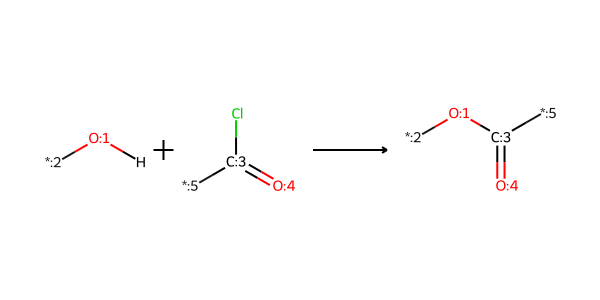

{0: <rdkit.Chem.rdchem.Mol object at 0x7f1b0098af10>, 1: <rdkit.Chem.rdchem.Mol object at 0x7f1b009898c0>}


In [25]:
rxn = AnnotatedReaction.from_smarts("[#8:1](-[*:2])-[H].[#17]-[#6:3](=[#8:4])-[*:5]>>[#8:1](-[*:2])-[#6:3](=[#8:4])-[*:5]")
# rxn = AnnotatedReaction.from_rxnfile('test.rxn')
reactant_templates_by_index = {i : reac_templ for i, reac_templ in enumerate(rxn.GetReactants())}

display(rxn)
print(reactant_templates_by_index)

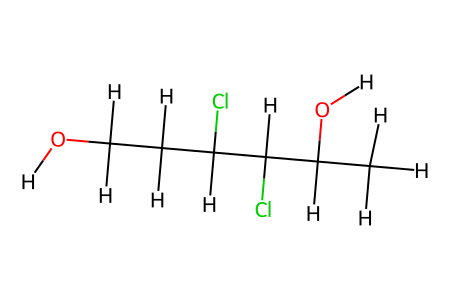

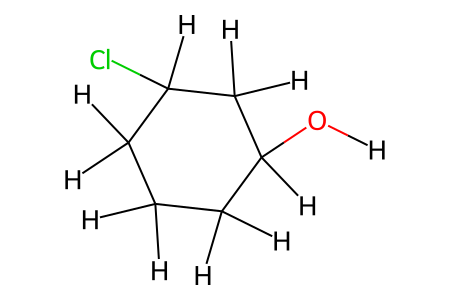

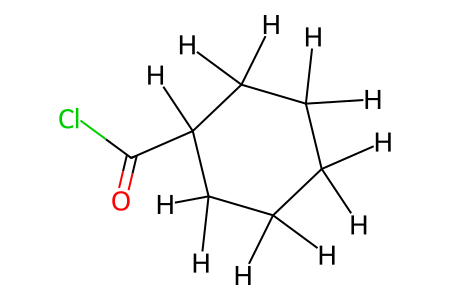

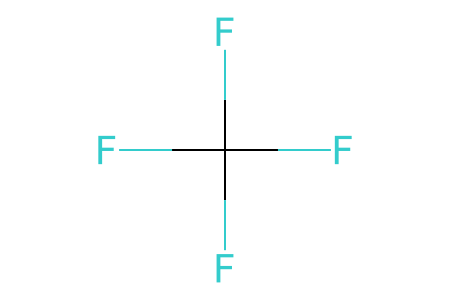

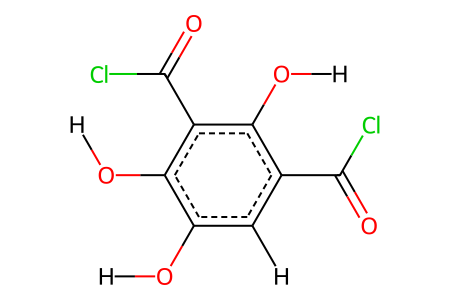

In [26]:
from polymerist.polymers.monomers.specification import expanded_SMILES

reactant_smiles = [
    'CC(O)C(Cl)C(Cl)CCO',
    'C1CCC(Cl)CC1O',
    'C1CCC(C(=O)Cl)CC1',
    'FC(F)(F)F',
    'c1(O)c(O)c(C(=O)Cl)c(O)c(C(=O)Cl)c1',
]

reactants = []
for smiles in reactant_smiles:
    exp_smiles = expanded_SMILES(smiles, assign_map_nums=False)
    mol = Chem.MolFromSmiles(exp_smiles, sanitize=False)
    Chem.SanitizeMol(mol)
    display(mol)
    reactants.append(mol)

PAIR 1
NO ORDER FOUND:
PAIR 2
ORDER FOUND:
++++++++++++++++++++++++++++++++++++++++++++++++++


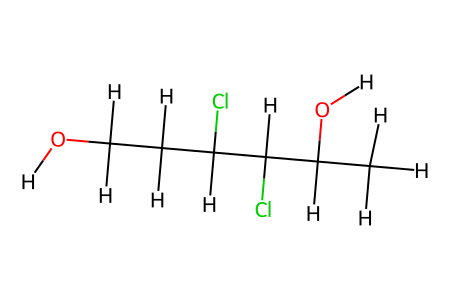

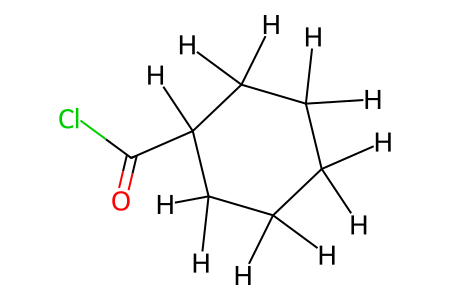

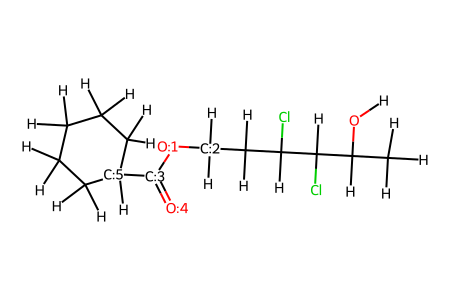

PAIR 3
NO ORDER FOUND:
PAIR 4
ORDER FOUND:
++++++++++++++++++++++++++++++++++++++++++++++++++


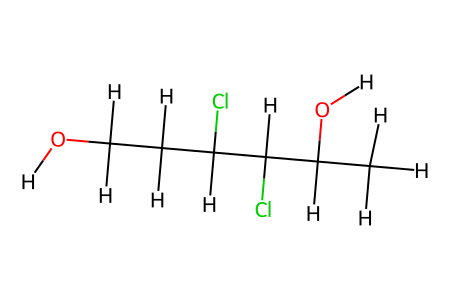

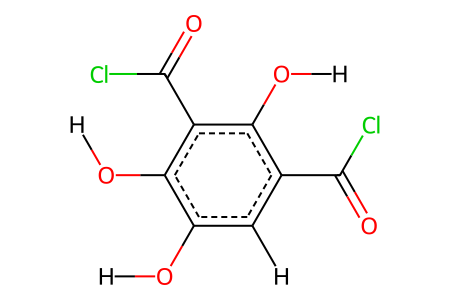

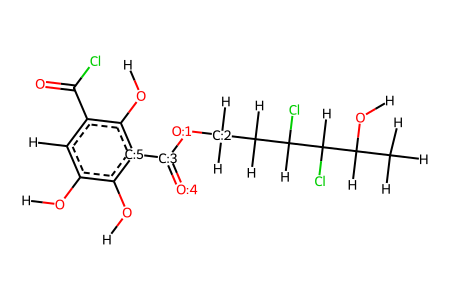

PAIR 5
ORDER FOUND:
++++++++++++++++++++++++++++++++++++++++++++++++++


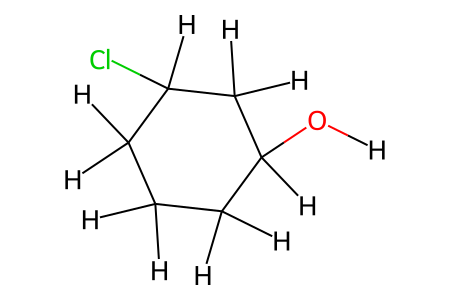

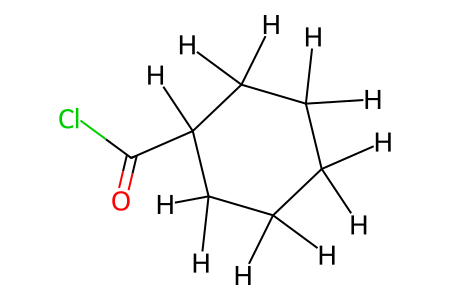

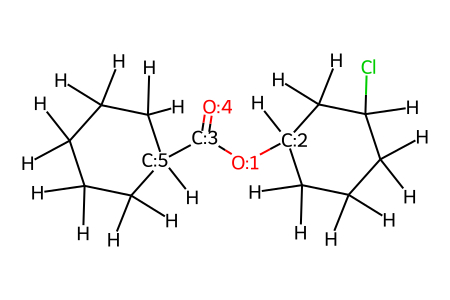

PAIR 6
NO ORDER FOUND:
PAIR 7
ORDER FOUND:
++++++++++++++++++++++++++++++++++++++++++++++++++


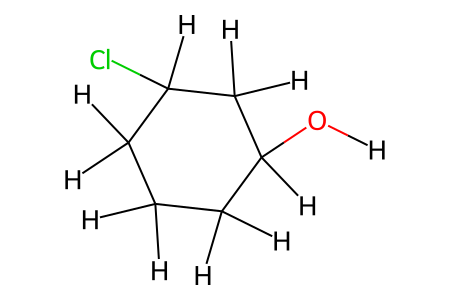

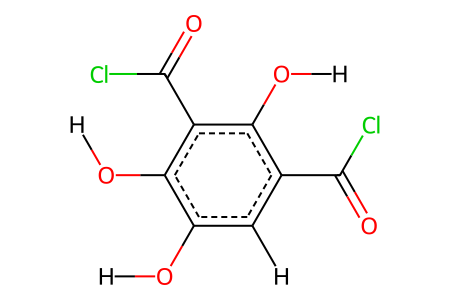

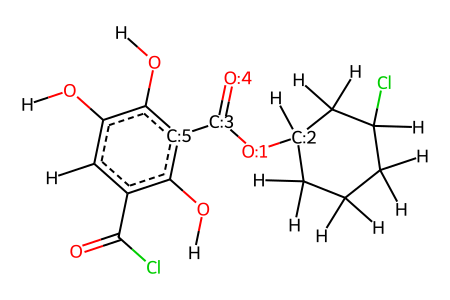

PAIR 8
NO ORDER FOUND:
PAIR 9
ORDER FOUND:
++++++++++++++++++++++++++++++++++++++++++++++++++


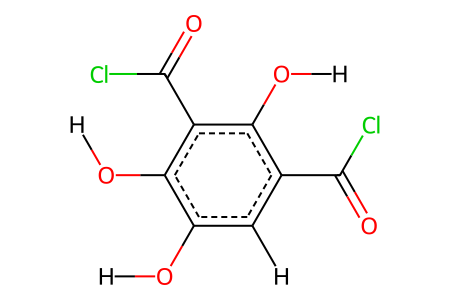

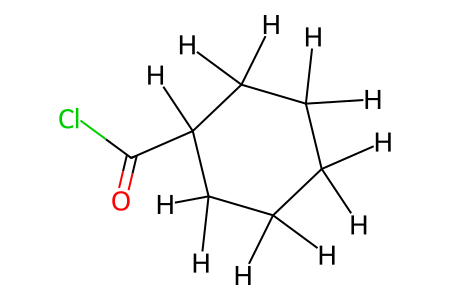

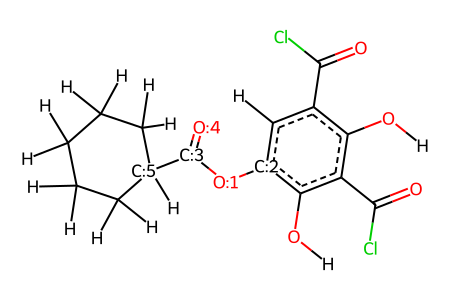

PAIR 10
NO ORDER FOUND:


In [27]:
from itertools import combinations
from polymerist.rdutils.reactions.reactors import Reactor


reactor = Reactor(rxn)
for i, rs in enumerate(combinations(reactants, 2)):
    print(f'PAIR {i+1}')
    (react1, react2) = rs
    reactant_order = rxn.valid_reactant_ordering(rs)
    if reactant_order is None:
        print('NO ORDER FOUND:')
    else:
        print('ORDER FOUND:')
        print('+'*50)
        for m in reactant_order:
            display(m)
            
        display(reactor.react(rs)[0])

    print('='*50)

adducts:


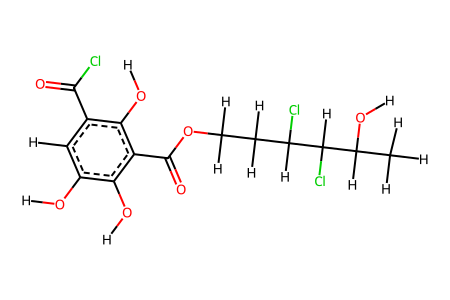

fragments:


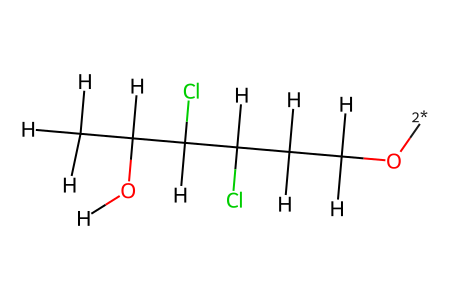

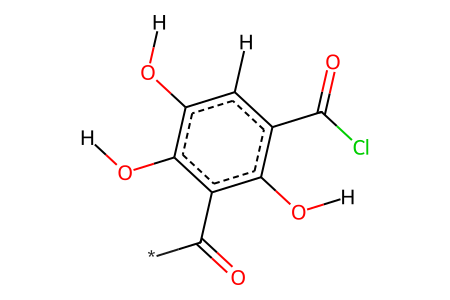

adducts:


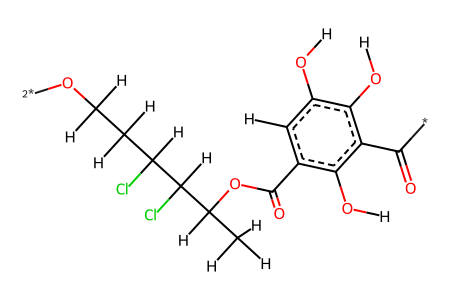

fragments:


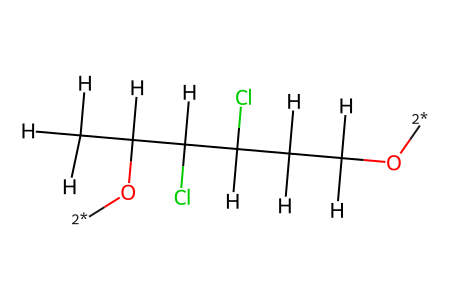

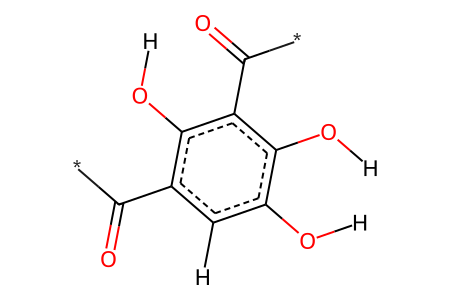

In [28]:
from polymerist.rdutils.reactions.reactors import Reactor, PolymerizationReactor

rs = [reactants[0], reactants[4]]
reactor = PolymerizationReactor(rxn)

for adducts, frags in reactor.propagate(rs):
    print('adducts:')
    for adduct in adducts:
        display(adduct)
        
    print('fragments:')
    for frag in frags:
        display(frag)
        
    print('='*50)

## Developing regex for recognizing numeric types in string form

In [93]:
import re

# consider switching to re.VERBOSE mode
INT_REGEX = re.compile(                 # DESCRIPTION: lookahead and fail is line ends contains any number of characters ending with underscore...
    '^(?!.*_$)[-+]?([1-9][_\d]*|0)$'    # ...Otherwise match line start, then optional plus or minus, then any nonzero digit followed by (possibly no)...
)                                       # ...other digits or underscores OR 0 by itself as a special case, and finally the end of line

tests = [
    # test "obvious" integer cases
    ('1', True),
    ('5', True),
    ('12', True),
    ('1232164', True),
    ('0', True), # in particular, 0 should absolutely be matched as an integer
    # test rejection of leading zeros (unless the number represented is identically zero)
    ('01', False),
    ('00004241', False),
    ('010101', False),
    # test rejection on words
    ('', False), # in particular), the empty string should not be recognized
    ('fbhf', False),
    ('a123', False),
    ('fubar', False),
    ('fubar69', False),
    # test plus signs
    ('+192', True),
    ('+a5sd', False),
    ('+0071', False),
    ('+0', True),
    # test minus signs
    ('-1232', True),
    ('-123x232', False),
    ('-0002', False),
    ('-0', True),
    # test underscores
    ('125_000', True),
    ('1_2_3_4', True),
    ('-10_', False), # in Python, underscores anywhere in a string EXCEPT at the end are valid for ints
    ('_99', False),
]

for test, expected_to_match in tests:
    # print(re.match(INT_REGEX, test), test, expected_to_match)
    print( (re.match(INT_REGEX, test) is not None) == expected_to_match )


True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
